# Transfer Learning
<hr style="border:2px solid black">

## 1. Introduction

**What is transfer learning?**
- one of the most powerful ideas of deep learning
- taking knowledge learned from one task, and leveraging it on a similar but new task

**Why transfer learning?**
- big pre-trained models can be leveraged
- good accuracy with very little training (saves training time)
- allows training with very small training datasets

**When transfer learning for task-A$\rightarrow$task-B useful?**
- same input type for both tasks
- big training data for task-A, but small training data for task-B
- low-level features of task-A useful for learning task-B

**How to implement transfer learning?**
1. take a pre-trained network, and remove its last layer(s)
2. replace the weights feeding into the last layer(s) with a new set of randomly intialized weights
3. Add new trainable layer(s) on top of the remaining layers
4. retrain the neural network on the new dataset; depending on dataset size:
    - `pre-training`: retrain only the weights of the newly added layer(s), freeze all the other layers
    - `fine tuning`: retrain the newly added layer(s) as well as some/all of the other layers

<hr style="border:2px solid black">

## 2. Pre-trained Model

### 2.1 Load packages

In [46]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# miscellaneous
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# deep learning stack
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

In [47]:
# tensorflow and keras version
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

TensorFlow version: 2.12.0
Keras version: 2.12.0


### 2.2 Load model

[`mobilenet_v2`](https://keras.io/api/applications/mobilenet/)

In [48]:
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2,
    preprocess_input,
    decode_predictions
)

**instantiate model**

In [49]:
pretrained_model = MobileNetV2(
    weights='imagenet'
)

**model summary**

In [ ]:
pretrained_model.summary()

### 2.3 User-defined functions

In [50]:
def load_image(image_path):
    """
    loads an input image into PIL format of size 224 X 224
    """
    img = image.load_img(
        path=image_path,
        target_size=(224,224)
    )
    return img

In [51]:
def batch_image(loaded_image):
    """
    converts a loaded image to a batch
    """
    img_array = image.img_to_array(loaded_image)
    img_batch = np.array([img_array])
    
    return img_batch

In [52]:
def preprocess_image(batched_image):
    """
    preprocesses a batch image to make suitable for mobilenet_v2
    """
    processed_img = preprocess_input(batched_image)
    
    return processed_img

In [53]:
def show_preprocess_image(image_path):
    """
    shows loaded image given an image path, and
    preprocesses it to make suitable for mobilenet_v2
    """
    # load resized image
    loaded_img = load_image(image_path)
    
    # display image
    plt.figure(figsize=(3,3), dpi=100)
    plt.imshow(loaded_img)
    
    # create batched image
    batch_img = batch_image(loaded_img)
    
    # preprocess image
    processed_img = preprocess_image(batch_img)
    
    return processed_img

In [54]:
def image_class_prediction(model, preprocessed_image):
    """
    spits out the top-5 predictions of a given model with a proprocessed image
    """
    model_prediction = model.predict(preprocessed_image,verbose=0)
    decoded_prediction = decode_predictions(model_prediction,top=5)[0]
    data = {
        'image_class': [_[1] for _ in decoded_prediction],
        'probability': [_[2] for _ in decoded_prediction]
    }
    df = pd.DataFrame(data=data)
    return df

### 2.4 Model evaluation

In [55]:
CLASSES = os.listdir('../data/train')
CLASSES = ['bananas', 'cellphones', 'spectacles', 'cups']
CLASSES

['bananas', 'cellphones', 'spectacles', 'cups']

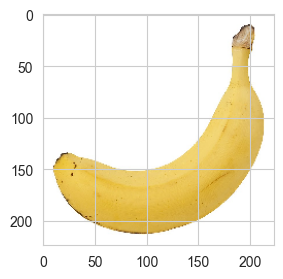

In [56]:
# show and preprocess image

banana_image = show_preprocess_image(
    '../data/test/bananas/bananas_03.jpg'
)

In [57]:
# class prediction

image_class_prediction(
    pretrained_model,
    banana_image
)

,image_class,probability
0,banana,0.978275
1,butternut_squash,0.001825
2,flatworm,0.001224
3,slug,0.001086
4,hook,0.000564


## 3. Transfer Learning Example

In [58]:
# instantiate image data generator

data_gen = image.ImageDataGenerator(
    # preprocessing function for all images
    preprocessing_function=preprocess_input
)

In [59]:
# generate batches of x and y arrays from directory

train_data_gen = data_gen.flow_from_directory(
        directory='../data/train',
        class_mode="categorical",
        classes=CLASSES,
        batch_size=400,
        target_size=(224,224)
)

Found 400 images belonging to 4 classes.


In [60]:
# load in all images at once

xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((400, 224, 224, 3), (400, 4))

### 3.1 Model Building 

**3.1.1 Select convolutional base with frozen weights**

In [61]:
# define base model

BASE_MODEL = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,          # controls number of overall weights
    include_top=False,  # removal of final dense layers
    pooling='avg',      # average pooling to last convolutional layer's ouput
    input_shape=(224,224,3) # ignored if input tensor is provided
)

In [62]:
# freeze base model
BASE_MODEL.trainable = False

In [63]:
# base model summary
BASE_MODEL.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**3.1.2 Add dense layers on top**

In [64]:
def HyperModel(hyperparameters):
    '''
    creates a hypermodel by stacking dense layers on top of base model. 
    Two hyperparameters to be tuned: 
    1. number of neurons in the first dense layer,
    2. initial learning rate of the optimizer
    Args:
    hyperparameters - Keras tuner object
    '''
    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(BASE_MODEL)
    
    # number of neurons in first dense layer
    hp_units = hyperparameters.Choice(
        'units', 
        values=[320,160,80]
    )
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=hp_units, 
            activation='relu'
        )
    )
    # dropout 
    model.add(
        keras.layers.Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    # learning rate for the optimizer
    hp_learning_rate = hyperparameters.Choice(
        'learning_rate', 
        values=[1e-2, 1e-3, 1e-4]
    )
    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp_learning_rate
        ),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )

    return model

### 3.2 Hyperparameter Tuning: [KerasTuner](https://keras.io/keras_tuner/)

In [65]:
import keras_tuner as kt

**grid search**

In [66]:
# instantiate hyperband

tuner = kt.GridSearch(
    hypermodel=HyperModel,
    objective='val_categorical_accuracy'
)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [67]:
# hypertuning settings summary
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Choice)
{'default': 320, 'conditions': [], 'values': [320, 160, 80], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [68]:
# early stopping

stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5
)

In [ ]:
# load and evaluate a saved model
#from numpy import loadtxt
#from tensorflow.keras.models import load_model

In [ ]:
# load model
#model = load_model('best_model.h5')

In [ ]:
#model.summary()

**Hypertuning**

In [69]:
tuner.search(
   xtrain, 
   ytrain,
   epochs=25,
   validation_split=0.2,
   callbacks=[stop_early]
)

INFO:tensorflow:Oracle triggered exit


In [70]:
# best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

In [71]:
best_hp.get('units')

320

In [72]:
best_hp.get('learning_rate')

0.0001

**Model selection**

In [73]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 320)               409920    
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1284      
                                                                 
Total params: 2,669,188
Trainable params: 411,204
Non-trainable params: 2,257,984
_________________________________________________________________


### 3.3 Model Training

**train model**

In [74]:
h_model.fit(
    xtrain,
    ytrain,
    epochs=40,
    batch_size=20,
    callbacks=[stop_early],
    validation_split=0.2
)

Epoch 1/40
16/16 [==============================] - 18s 877ms/step - loss: 1.2455 - categorical_accuracy: 0.4812 - val_loss: 0.6914 - val_categorical_accuracy: 0.8000
Epoch 2/40
16/16 [==============================] - 14s 870ms/step - loss: 0.6874 - categorical_accuracy: 0.7469 - val_loss: 0.4202 - val_categorical_accuracy: 0.9125
Epoch 3/40
16/16 [==============================] - 17s 1s/step - loss: 0.4227 - categorical_accuracy: 0.8656 - val_loss: 0.2949 - val_categorical_accuracy: 0.9500
Epoch 4/40
16/16 [==============================] - 12s 780ms/step - loss: 0.2653 - categorical_accuracy: 0.9344 - val_loss: 0.2325 - val_categorical_accuracy: 0.9750
Epoch 5/40
16/16 [==============================] - 11s 702ms/step - loss: 0.2083 - categorical_accuracy: 0.9531 - val_loss: 0.1925 - val_categorical_accuracy: 0.9875
Epoch 6/40
16/16 [==============================] - 11s 691ms/step - loss: 0.1730 - categorical_accuracy: 0.9656 - val_loss: 0.1682 - val_categorical_accuracy: 0.9875
E

**training history: losses and epoch numbers**

In [75]:
# losses in the training history
losses = pd.DataFrame(h_model.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

**plot training history**

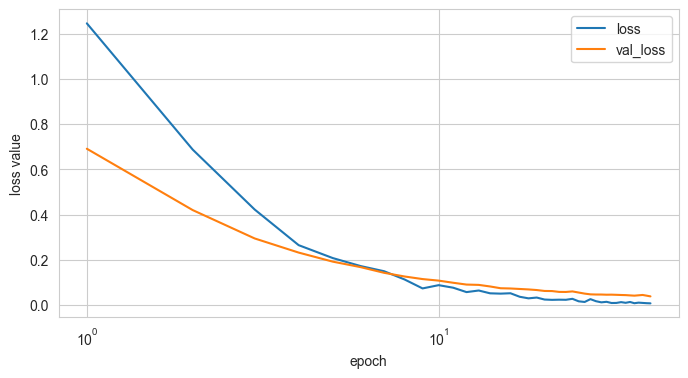

In [76]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,4),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=10)
plt.ylabel('loss value',fontsize=10)
plt.legend(loc=1,fontsize=10);

### 3.4 Model Evaluation

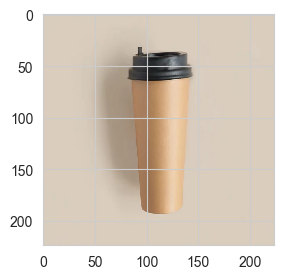

In [77]:
# show and preprocess image
test_image = show_preprocess_image('../data/test/cups/cups_02.jpg')

In [78]:
def image_predict(preprocessed_image, model):
    """
    returns class probabilities for a given image,
    based on the model obtained via transfer learning 
    """
    probabilities = model.predict(
        preprocessed_image,
        verbose=0
    )
    probabilities = np.round(probabilities,6)[0]
    class_probabilities = dict(zip(CLASSES,probabilities))
    
    return class_probabilities

In [79]:
# predict image class
image_predict(test_image, h_model)

{'bananas': 0.010924,
 'cellphones': 0.008984,
 'spectacles': 0.003236,
 'cups': 0.976856}

In [81]:
# generate batches of x and y arrays from directory

test_data_gen = data_gen.flow_from_directory(
        directory='../data/test',
        class_mode="categorical",
        classes=CLASSES,
        target_size=(224, 224)
)

Found 40 images belonging to 4 classes.


In [82]:
# load in all images at once
xtest, ytest = next(test_data_gen)
xtest.shape, ytest.shape

((32, 224, 224, 3), (32, 4))

In [83]:
def transfer_learning_prediction(model, x, y):
    """
    returns dataframe with class probabilities and true class label 
    """
    # prediction dataframe along with true class
    df_pred = pd.DataFrame(
        columns=CLASSES,
        data=np.round(model.predict(x,verbose=0),6)
    )
    # convert vectorized classes into strings
    df_pred['class'] = \
    [''.join([i*j for (i,j) in zip(CLASSES,vector)]) for vector in y.astype(int)]
    
    return df_pred

In [84]:
# model predictions

test_prediction = transfer_learning_prediction(
    h_model,
    xtest,
    ytest
)

test_prediction

,bananas,cellphones,spectacles,cups,class
0,0.000010,0.000003,0.999973,0.000014,spectacles
1,0.992390,0.000361,0.000336,0.006914,bananas
2,0.000392,0.000049,0.997383,0.002176,spectacles
3,0.000821,0.000053,0.000596,0.998530,cups
4,0.995832,0.000567,0.000725,0.002876,bananas
5,0.998153,0.000211,0.000363,0.001273,bananas
6,0.009995,0.971630,0.008539,0.009836,cellphones
7,0.000220,0.996556,0.000183,0.003042,cellphones
8,0.048726,0.216698,0.353033,0.381542,spectacles
9,0.040810,0.006763,0.008108,0.944319,cups


In [85]:
def accuracy_score(model,x,y):
    """
    This function spits out multi-class accuracy
    """
    grouped_df = transfer_learning_prediction(
        model, x, y
    ).groupby('class').sum()
    
    grouped_df.sort_index(axis=1,inplace=True)
    
    accuracy_score = np.trace(grouped_df)/np.array(grouped_df).sum()
    accuracy_score = round(accuracy_score,6)
    
    return accuracy_score

In [86]:
accuracy_score(h_model, xtest, ytest)

0.91433

In [87]:
accuracy_score(h_model, xtrain, ytrain)

0.991485

<hr style="border:2px solid black">

## References

1. [Transfer Learning, Andrew Ng](https://www.youtube.com/watch?v=yofjFQddwHE)

2. [Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)